In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time

%matplotlib inline

In [2]:
# Personal Loan 데이터 불러오기
ploan = pd.read_csv('./Personal Loan.csv')
ploan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


# Lasso & Ridge

In [3]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [4]:
ploan_processed = ploan.dropna().drop(['ID', 'ZIP Code'], axis = 1, inplace = False)

feature_columns = list(ploan_processed.columns.difference(['Personal Loan']))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan']

train_x, test_x, train_y, test_y = train_test_split(X, y, stratify = y, train_size = 0.7, test_size = 0.3, random_state = 42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1750, 11) (750, 11) (1750,) (750,)


In [5]:
# Lasso 적합
ll = Lasso(alpha = 0.01)
ll.fit(train_x, train_y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [6]:
# 회귀 계수 출력
ll.coef_

array([ 0.00000000e+00,  2.04783983e-03,  1.14390390e-01, -0.00000000e+00,
        6.58342418e-02,  4.76625359e-04,  3.13396711e-02,  3.55393865e-03,
        1.31719530e-05,  0.00000000e+00, -0.00000000e+00])

In [7]:
print(dir(ll))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_decision_function', '_estimator_type', '_get_param_names', '_get_tags', '_more_tags', '_preprocess_data', '_set_intercept', 'alpha', 'coef_', 'copy_X', 'dual_gap_', 'fit', 'fit_intercept', 'get_params', 'intercept_', 'l1_ratio', 'max_iter', 'n_iter_', 'normalize', 'path', 'positive', 'precompute', 'predict', 'random_state', 'score', 'selection', 'set_params', 'sparse_coef_', 'tol', 'warm_start']


In [8]:
def cut_off(y, threshold):
    Y = y.copy()  # copy 함수를 사용하여 이전의 y 값이 변하지 않도록 함
    Y[Y > threshold] = 1
    Y[Y <= threshold] = 0
    return Y.astype(int)    

In [10]:
# confusion matrix accuracy
def calculate_acc(cf_matrix):
    return (cf_matrix[0, 0] + cf_matrix[1, 1]) / (cf_matrix[0, 0] + cf_matrix[0, 1] + cf_matrix[1, 0] + cf_matrix[1, 1])

In [11]:
# 예측
pred_y_lasso = ll.predict(test_x)
pred_Y_lasso = cut_off(pred_y_lasso, 0.5)
cfmat = confusion_matrix(test_y, pred_Y_lasso)
print(calculate_acc(cfmat))

0.936


In [12]:
# ridge 적합

In [13]:
rr = Ridge(alpha = 0.01)
rr.fit(train_x, train_y)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
rr.coef_

array([-3.71283678e-03,  7.37570775e-03,  3.54973975e-01, -5.28579506e-02,
        7.83404224e-02,  4.12823466e-03,  3.62504712e-02,  3.27385112e-03,
        1.73105480e-06, -1.91297381e-02, -8.77388670e-02])

In [15]:
# 예측
pred_y_ridge = rr.predict(test_x)
pred_Y_ridge = cut_off(pred_y_ridge, 0.5)
cfmat = confusion_matrix(test_y, pred_Y_ridge)
print(calculate_acc(cfmat))

0.932


In [16]:
# lambda(alpha)값에 따른 회귀 계수 / accuracy 계산

In [18]:
# lambda값을 0.001 ~ 10까지 범위 설정
alpha = np.logspace(base=10.0, start=-3, stop=1, num=5)

In [28]:
# Lasso

data = []
acc_table = []
for idx, value in enumerate(alpha):
    lasso = Lasso(alpha=value).fit(train_x, train_y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))   # 행 방향으로 절편과 계수 값을 추가 -> Series -> list append
    pred_y = lasso.predict(test_x)   # full model
    pred_Y = cut_off(pred_y, 0.5)
    cfmat = confusion_matrix(test_y, pred_Y)
    acc_table.append(calculate_acc(cfmat))
    
print(data)
print(acc_table)

[0    -0.335006
1    -0.002109
2     0.006829
3     0.322174
4    -0.043385
5     0.076771
6     0.002534
7     0.035728
8     0.003313
9     0.000004
10   -0.012241
11   -0.067973
dtype: float64, 0    -0.381869
1     0.000000
2     0.002048
3     0.114390
4    -0.000000
5     0.065834
6     0.000477
7     0.031340
8     0.003554
9     0.000013
10    0.000000
11   -0.000000
dtype: float64, 0    -0.143698
1     0.000000
2     0.000000
3     0.000000
4    -0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.003291
9     0.000016
10    0.000000
11    0.000000
dtype: float64, 0    -0.113103
1     0.000000
2     0.000000
3     0.000000
4    -0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.002893
9     0.000000
10    0.000000
11    0.000000
dtype: float64, 0     0.102286
1    -0.000000
2     0.000000
3     0.000000
4    -0.000000
5     0.000000
6    -0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
dtype: float64]
[0.932, 0.936, 0.89

In [43]:
# df_lasso = pd.DataFrame(data)
df_lasso = pd.DataFrame(data, index=alpha).T
df_lasso.index = ['intercept'] + feature_columns
df_lasso

,0.001,0.010,0.100,1.000,10.000
intercept,-0.335006,-0.381869,-0.143698,-0.113103,0.102286
Age,-0.002109,0.000000,0.000000,0.000000,-0.000000
CCAvg,0.006829,0.002048,0.000000,0.000000,0.000000
CD Account,0.322174,0.114390,0.000000,0.000000,0.000000
CreditCard,-0.043385,-0.000000,-0.000000,-0.000000,-0.000000
Education,0.076771,0.065834,0.000000,0.000000,0.000000
Experience,0.002534,0.000477,0.000000,0.000000,-0.000000
Family,0.035728,0.031340,0.000000,0.000000,0.000000
Income,0.003313,0.003554,0.003291,0.002893,0.000000
Mortgage,0.000004,0.000013,0.000016,0.000000,0.000000


In [35]:
# acc_table_lasso = pd.DataFrame(acc_table)
acc_table_lasso = pd.DataFrame(acc_table, index = alpha, columns=['Accuracy']).T
acc_table_lasso

,0.001,0.010,0.100,1.000,10.000
Accuracy,0.932,0.936,0.894667,0.897333,0.897333


In [44]:
# Ridge

data2 = []
acc_table2 = []
for idx, value in enumerate(alpha):
    ridge = Ridge(alpha=value).fit(train_x, train_y)
    data2.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))   # 행 방향으로 절편과 계수 값을 추가 -> Series -> list append
    pred_y = ridge.predict(test_x)   # full model
    pred_Y = cut_off(pred_y, 0.5)
    cfmat = confusion_matrix(test_y, pred_Y)
    acc_table2.append(calculate_acc(cfmat))
    
df_ridge = pd.DataFrame(data2, index=alpha).T
df_ridge.index = ['intercept'] + feature_columns
acc_table_ridge = pd.DataFrame(acc_table2, index = alpha, columns=['Accuracy']).T

In [45]:
df_ridge

,0.001,0.010,0.100,1.000,10.000
intercept,-0.289557,-0.289565,-0.289645,-0.290438,-0.297581
Age,-0.003713,-0.003713,-0.003713,-0.003716,-0.003723
CCAvg,0.007376,0.007376,0.007376,0.007378,0.007388
CD Account,0.355019,0.354974,0.354529,0.350141,0.311781
CreditCard,-0.052866,-0.052858,-0.052782,-0.052037,-0.045541
Education,0.078340,0.078340,0.078341,0.078347,0.078316
Experience,0.004128,0.004128,0.004129,0.004136,0.004175
Family,0.036250,0.036250,0.036254,0.036289,0.036578
Income,0.003274,0.003274,0.003274,0.003278,0.003313
Mortgage,0.000002,0.000002,0.000002,0.000002,0.000004


In [38]:
acc_table_ridge

,0.001,0.010,0.100,1.000,10.000
Accuracy,0.932,0.932,0.932,0.932,0.932


# lambda 값에 따른 회귀계수 축소 시각화

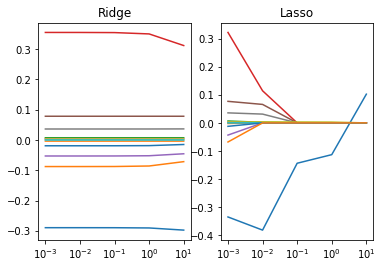

In [40]:
ax1 = plt.subplot(121)
plt.semilogx(df_ridge.T)
plt.xticks(alpha)
plt.title("Ridge")

ax2 = plt.subplot(122)
plt.semilogx(df_lasso.T)
plt.xticks(alpha)
plt.title("Lasso")

plt.show()